##### This script will associate spoken phrases with their corresponding translation, using a convolutional neural network ("CNN")

This CNN will rely on all phrases from Female 1 that were spoken more than once, and have a recording using each of the two mics - head and array. The resulting data will have 4 or more records for each prompt. These records will be randomly assigned to train/test by prompt id using a 50/50 split. (e.g. for Female 1, the prompt "chair" was recorded twice in prompt id 46 and 73. In this case the head and array mic recording from prompt id 46 will be used for training, and then head and array mic recordings from prompt id 73 will be used for testing)

In the end, if the CNN can use the phrase spoken in one prompt to predict the same phrase spoken in another prompt, even though it has not used the other prompt to learn, then that should prove this approach should work.

In [ ]:
# ##### CNN Parameters #####

batch_size = 10 
epochs = 80

pad_images = False       # Pad images before resizing?
image_height_width = 56  # Resize all images to square with this height and width

###########################

In [1]:
# Load packages

import pandas as pd
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

C:\Users\mpowers\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 1) Load and Filter Data

In [2]:
# Load master index, and filter and assign to train and test using pandas

# *** Load prompt_id as text with leading zeros
df = pd.read_csv('../index_TORGO.txt', sep="|", converters={'prompt_id': lambda x: str(x)})

# Remove instances where prompt is None OR prompts that begin with "[" or contain "jpg" OR where has_spect is No
df['remove'] = (df['prompt']==None) | (df['prompt']=='None') | (df['prompt'].str.contains('jpg')) | (df['prompt'].str.startswith('[')) | (df['has_spect']=='No')

print('Number of rows:', df.shape[0])
print('Number of rows set to remove:', df[df['remove']==True].shape[0])
df.head(20)

Number of rows: 6179
Number of rows set to remove: 523


,speaker,session,mic,prompt_id,has_spect,spect_width,spect_height,prompt,remove
0,F01,Session1,wav_headMic,0001,yes,320,513,[say Ah-P-Eee repeatedly],True
1,F01,Session1,wav_headMic,0002,yes,295,513,[say Ah-P-Eee repeatedly],True
2,F01,Session1,wav_headMic,0003,yes,242,513,[say Pah-Tah-Kah repeatedly],True
3,F01,Session1,wav_headMic,0004,yes,301,513,[say Eee-P-Ah repeatedly],True
4,F01,Session1,wav_headMic,0005,yes,240,513,[relax your mouth in its normal position],True
5,F01,Session1,wav_headMic,0006,yes,44,513,stick,False
6,F01,Session1,wav_headMic,0007,yes,71,513,tear [as in tear up that paper],False
7,F01,Session1,wav_headMic,0008,yes,308,513,Except in the winter when the ooze or snow or ...,False
8,F01,Session1,wav_headMic,0009,yes,40,513,pat,False
9,F01,Session1,wav_headMic,0010,yes,65,513,up,False


In [3]:
# Only keep instances where the recording was made on both the head and array mics
df = df[df['remove']==False]

df_head = df[(df['mic']=='wav_headMic')]
df_array = df[(df['mic']=='wav_arrayMic')]

df_filter = pd.merge(df_head, df_array, on=['speaker','session','prompt_id'])
print('Number of rows after filter and join in filter df:', df_filter.shape[0])
keep_id = df_filter['speaker'] + df_filter['session'] + df_filter['prompt_id']

df['keep_id'] = df['speaker'] + df['session'] + df['prompt_id']
df = df[df.keep_id.isin(keep_id)]
print('Number of rows after filter and join in df:', df.shape[0])  # Should be 2x the rows in the filter df

Number of rows after filter and join in filter df: 2471
Number of rows after filter and join in df: 4942


In [4]:
# Only keep instances where a prompt was recorded more than once

df_filter = df.groupby(['speaker','mic','prompt']).size().reset_index(name='counts')
df_filter = df_filter[df_filter['counts']>1]
keep_id = df_filter['speaker'] + df_filter['prompt']

df['keep_id'] = df['speaker'] + df['prompt']
df = df[df.keep_id.isin(keep_id)]
print('Number of rows after removing prompts only recorded once:', df.shape[0])

Number of rows after removing prompts only recorded once: 1422


In [5]:
df = df.sort_values(by=['speaker','prompt','prompt_id','mic'])
df.head(10)

,speaker,session,mic,prompt_id,has_spect,spect_width,spect_height,prompt,remove,keep_id
163,F01,Session1,wav_arrayMic,0030,yes,165,513,The quick brown fox jumps over the lazy dog.,False,F01The quick brown fox jumps over the lazy dog.
29,F01,Session1,wav_headMic,0030,yes,151,513,The quick brown fox jumps over the lazy dog.,False,F01The quick brown fox jumps over the lazy dog.
164,F01,Session1,wav_arrayMic,0031,yes,155,513,The quick brown fox jumps over the lazy dog.,False,F01The quick brown fox jumps over the lazy dog.
30,F01,Session1,wav_headMic,0031,yes,145,513,The quick brown fox jumps over the lazy dog.,False,F01The quick brown fox jumps over the lazy dog.
148,F01,Session1,wav_arrayMic,0015,yes,57,513,air,False,F01air
14,F01,Session1,wav_headMic,0015,yes,67,513,air,False,F01air
212,F01,Session1,wav_arrayMic,0079,yes,61,513,air,False,F01air
78,F01,Session1,wav_headMic,0079,yes,39,513,air,False,F01air
162,F01,Session1,wav_arrayMic,0029,yes,57,513,beat,False,F01beat
28,F01,Session1,wav_headMic,0029,yes,50,513,beat,False,F01beat


## 2) Assign Data to Test and Train Sets

In [6]:
# Using the head Mic data, Sort the df by speaker, prompt, and prompt id
# Alternate assigning each row to train and test
# Then use that to join the assignment to the main dataframe, in order to tag the array Mic data with train/test

df_filter = df[df['mic']=='wav_headMic'].sort_values(by=['speaker','prompt','prompt_id'])

df_filter['train'] = 0
train = 1
for index, row in df_filter.iterrows():
    df_filter.at[index,'train'] = train
    train *= -1

df_filter = df_filter[['speaker','session','prompt_id','train']]

df = pd.merge(df, df_filter, on=['speaker','session','prompt_id'])

In [7]:
# *** FOR NOW ONLY USE FEMALE 1 *** We can alter this later
df = df[df['speaker']=='F01']

# Add numerical prompt codes once final data set is compiled
df.prompt = pd.Categorical(df.prompt)
df['prompt_code'] = df.prompt.cat.codes

df.head(80)

num_classes = df['prompt_code'].max() + 1
print('Number of rows for Female 1:', df.shape[0])
print('Number of unique prompts for Female 1: ', num_classes)

Number of rows for Female 1: 78


,speaker,session,mic,prompt_id,has_spect,spect_width,spect_height,prompt,remove,keep_id,train,prompt_code
0,F01,Session1,wav_arrayMic,0030,yes,165,513,The quick brown fox jumps over the lazy dog.,False,F01The quick brown fox jumps over the lazy dog.,1,0
1,F01,Session1,wav_headMic,0030,yes,151,513,The quick brown fox jumps over the lazy dog.,False,F01The quick brown fox jumps over the lazy dog.,1,0
2,F01,Session1,wav_arrayMic,0031,yes,155,513,The quick brown fox jumps over the lazy dog.,False,F01The quick brown fox jumps over the lazy dog.,-1,0
3,F01,Session1,wav_headMic,0031,yes,145,513,The quick brown fox jumps over the lazy dog.,False,F01The quick brown fox jumps over the lazy dog.,-1,0
4,F01,Session1,wav_arrayMic,0015,yes,57,513,air,False,F01air,1,1
5,F01,Session1,wav_headMic,0015,yes,67,513,air,False,F01air,1,1
6,F01,Session1,wav_arrayMic,0079,yes,61,513,air,False,F01air,-1,1
7,F01,Session1,wav_headMic,0079,yes,39,513,air,False,F01air,-1,1
8,F01,Session1,wav_arrayMic,0029,yes,57,513,beat,False,F01beat,1,2
9,F01,Session1,wav_headMic,0029,yes,50,513,beat,False,F01beat,1,2


## 3) Pad and Resize Images

#### *once working, we should test just resizing the original images to squares, and not add any padding

This model will rely on the spectrogram images we generated from each audio file. I believe the CNN requires these images to be the same size. They are currenly all the same height (frequency axis), but are not the same width (time axis). Therefore, I will pad the end of each image so that all of the images are also the same width - using the max width of all the images.

Further research suggests that the images should be squares, and dimensions should be an even number since they may be divided by two one or twice. I will pad the bottom of the y axis (frequency) with a replication of what is above it, that way the information is still useful for prediction, rather than just padding it with gray like the x axis (time) axis.

There is also re-sizing at the end. I added the option to resize without padding.

[Tutorial for Padding with OpenCV](https://docs.opencv.org/3.1.0/d3/df2/tutorial_py_basic_ops.html)

In [9]:
# Get max width / height, which all images will be padded up to on both axis to make a square
# Force it to be an even number, and able to be divided by 2 twice  -->
#   Initially did this when I thought we could fit the entire image through the CNN. Now I realize they are too big.

maxwidth = int(df['spect_width'].max())
maxheight = int(df['spect_height'].max())

print('Max width:', maxwidth)
print('Max height:', maxheight)

if maxwidth <= maxheight:
    maxwidth = maxheight
    
if (maxwidth % 2) == 1:
    maxwidth += 1

if maxwidth/4 != 0:
    maxwidth += 2
    
print('Height and width to resize to:', maxwidth)

Max width: 76
Max height: 513
Height and width to resize to: 516


Shape before: (513, 165)
Shape after: (516, 516)


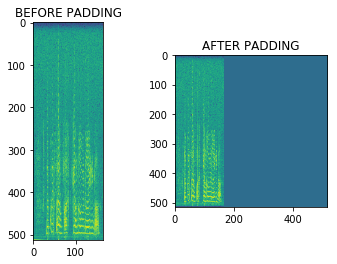

In [10]:
# View example of before and after padding. This is just an example!

img_loc = '/'.join(['../data/TORGO', df['speaker'][0], df['session'][0], df['mic'][0]+'_spect', df['prompt_id'][0]+'.png'])

# Image before padding
img = cv2.imread(img_loc, 0)
#PADCOLOR = int(img[0,0])
PADCOLOR = 132
imgplot = plt.subplot(121),plt.imshow(img),plt.title('BEFORE PADDING')
print('Shape before:', img.shape)

# Image after padding
pad = maxwidth - img.shape[1] # pad width with gray
img_new = cv2.copyMakeBorder(img,0,0,0,pad,cv2.BORDER_CONSTANT,value=PADCOLOR)
pad = maxwidth - img.shape[0] # pad height with replication
img_new = cv2.copyMakeBorder(img_new,0,pad,0,0,cv2.BORDER_WRAP)
print('Shape after:', img_new.shape)

imgplot_new = plt.subplot(122),plt.imshow(img_new),plt.title('AFTER PADDING')

In [11]:
# Get all predictor variables (padded images) and outcome variable (prompt)
images = []
prompts = []
train = []

for index, row in df.iterrows(): 
    img_loc = '/'.join(['../data/TORGO', row['speaker'], row['session'], row['mic']+'_spect', row['prompt_id']+'.png'])
    img = cv2.imread(img_loc, 0)
    
    # Pad images if set to true
    if pad_images:
        PADCOLOR = 132
        pad = maxwidth - img.shape[1] # pad width with gray
        img_new = cv2.copyMakeBorder(img,0,0,0,pad,cv2.BORDER_CONSTANT,value=PADCOLOR)
        pad = maxwidth - img.shape[0] # pad height with replication
        img_new = cv2.copyMakeBorder(img_new,0,pad,0,0,cv2.BORDER_WRAP)
        images.append(img_new)
    # Do not pad images
    else:
        images.append(img)
        
    prompts.append(row['prompt_code'])
    train.append(row['train'])

In [12]:
# View first 10 records, and verify images are all the same size if padded
print(prompts[0:10])
print(train[0:10])

for i in images[0:10]:
    print(i.shape)

[0, 0, 0, 0, 1, 1, 1, 1, 2, 2]
[1, 1, -1, -1, 1, 1, -1, -1, 1, 1]
(513, 165)
(513, 151)
(513, 155)
(513, 145)
(513, 57)
(513, 67)
(513, 61)
(513, 39)
(513, 57)
(513, 50)


(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)


(<matplotlib.image.AxesImage at 0x26b81454f98>,
 Text(0.5,1,'AFTER PADDING and SHRINK'))

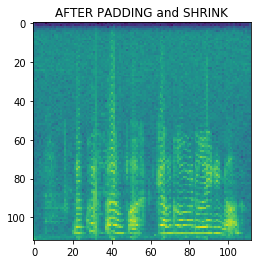

In [13]:
# Resize Images

maxwidth = image_height_width

images_shrunk = []
for i in images:
    images_shrunk.append(cv2.resize(i, (maxwidth, maxwidth)))

images = images_shrunk
for i in images[0:10]:
    print(i.shape)

plt.imshow(images[0]),plt.title('AFTER PADDING and SHRINK')

## 4) Set up and run CNN

In [14]:
import keras
from keras.datasets import mnist
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
import matplotlib.pylab as plt

Using TensorFlow backend.


In [16]:
# Split data into training and testing
x_train = np.array([images[i] for i,x in enumerate(train) if x==1])
y_train = np.array([prompts[i] for i,x in enumerate(train) if x==1])
x_test = np.array([images[i] for i,x in enumerate(train) if x==-1])
y_test = np.array([prompts[i] for i,x in enumerate(train) if x==-1])

print('Number of training records:', len(y_train))
print('Number of test records:', len(y_test))

Number of training records: 40
Number of test records: 38


In [17]:
# input image dimensions
img_x, img_y = maxwidth, maxwidth

In [18]:
# reshape the data into a 4D tensor - (sample_number, x_img_size, y_img_size, num_channels)
# because it is in greyscale, we only have a single channel - RGB colour images would have 3
x_train = x_train.reshape(x_train.shape[0], img_x, img_y, 1)
x_test = x_test.reshape(x_test.shape[0], img_x, img_y, 1)
input_shape = (img_x, img_y, 1)

In [19]:
# convert the data to the right type
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (40, 112, 112, 1)
40 train samples
38 test samples


In [20]:
# convert class vectors to binary class matrices - this is for use in the
# categorical_crossentropy loss below
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [21]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [22]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [23]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.val_acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))

In [24]:
history = AccuracyHistory()

In [25]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[history])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 40 samples, validate on 38 samples
Epoch 1/50
40/40 [==============================] - 8s 198ms/step - loss: 4.5860 - acc: 0.0000e+00 - val_loss: 2.9549 - val_acc: 0.0526
Epoch 2/50
40/40 [==============================] - 6s 139ms/step - loss: 2.9355 - acc: 0.0250 - val_loss: 2.8955 - val_acc: 0.0526
Epoch 3/50
40/40 [==============================] - 6s 144ms/step - loss: 2.8939 - acc: 0.1000 - val_loss: 2.8960 - val_acc: 0.0526
Epoch 4/50
40/40 [==============================] - 6s 145ms/step - loss: 2.8940 - acc: 0.0500 - val_loss: 2.8968 - val_acc: 0.0526
Epoch 5/50
40/40 [==============================] - 6s 147ms/step - loss: 2.8700 - acc: 0.1000 - val_loss: 2.9108 - val_acc: 0.0526
Epoch 6/50
40/40 [==============================] - 6s 145ms/step - loss: 2.9138 - acc: 0.0500 - val_loss: 2.9447 - val_acc: 0.0526
Epoch 7/50
40/40 [==============================] - 6s 148ms/step - loss: 2.8901 - acc: 0.1000 - val_loss: 2.8930 - val_acc: 0.0526
Epoch 8/50
40/40 [==========

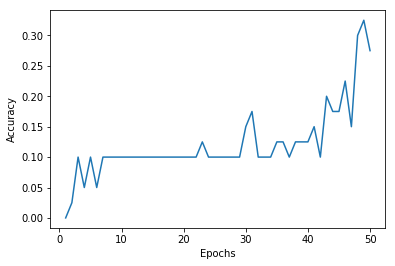

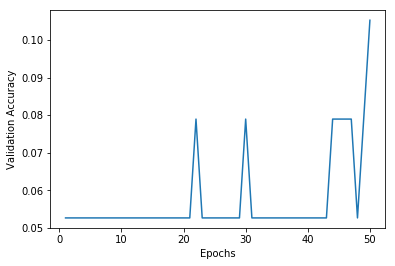

In [26]:
plt.plot(range(1, epochs + 1), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
plt.plot(range(1, epochs + 1), history.val_acc)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

##### Notes on results:

1) Maxwidth 56, resize with padding, 150 epochs, batch size 10
- The issue seems to be that most of the images are taken up by padding, and not providing predictive value
- Accuracy got up to around 65% and was still climbing? Test accuracy got up around 15/20% and was potentially still climbing?

2) Maxwidth 56, resize without padding, 100 epochs, batch size 10
- This learns, but overfits. Training accuracy gets to 100%. Test accuracy around 15%, up to 20%

3) Try larger width (resize without padding) with less epochs. Max width 112, 50 epochs, batch size 10
- This learns much slower. Would need to run for more epochs to determine outcome.